In [62]:
using Flux
using BSON
using MLDatasets
using Flux.Optimise: update!, train!
using Flux.Data: DataLoader
using Flux: logitbinarycrossentropy
using ProgressMeter: Progress, next!
using Plots
using PyPlot

In [2]:
# Load data sets
X,Y = MLDatasets.MNIST.traindata(Float32)

# Image to vector
X = reshape(X, 28^2, :)

# Data shape
D,N = size(X)

# Start DataLoader
data = DataLoader(X,Y, batchsize=32, shuffle=true)

DataLoader((Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [5, 0, 4, 1, 9, 2, 1, 3, 1, 4  …  9, 2, 9, 5, 1, 8, 3, 5, 6, 8]), 32, 60000, true, 60000, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  59991, 59992, 59993, 59994, 59995, 59996, 59997, 59998, 59999, 60000], true)

In [3]:
function encoder(; input_dim=2, hidden_dim=3, latent_dim=1, nonlinearity=tanh)
    "Mapping from observed space to latent space"

    # Map input to hidden layer
    h = Dense(input_dim, hidden_dim, nonlinearity)

    # Map hidden layer activity to mean and log-variance
    μ = Chain(h, Dense(hidden_dim, latent_dim, nonlinearity))
    logσ = Chain(h, Dense(hidden_dim, latent_dim, nonlinearity))

    return μ, logσ
end

encoder (generic function with 1 method)

In [4]:
function decoder(; latent_dim=1, hidden_dim=3, input_dim=2, nonlinearity=tanh)
   "Mapping from latent space to observed space" 
    
    # Latent to hidden
    h = Dense(latent_dim, hidden_dim, nonlinearity)
    
    # Hidden to input
    return Chain(h, Dense(hidden_dim, input_dim, nonlinearity))
end

decoder (generic function with 1 method)

In [5]:
function reconstruct(x, encoder, decoder)
   "Apply encoder and decoder to data"
    
    # Number of samples
    input_dim, num_samples = size(x)
    
    # Encode samples
    μ = encoder[1](x)
    logσ = encoder[2](x)
    
    # Dimensionality of latent space
    latent_dim = size(μ,1)
    
    # Generate samples in latent space
    z = μ + randn(Float32, (latent_dim, num_samples)) .* exp.(logσ)
    
    # Decode generated samples
    x_hat = decoder(z)  
    
    return μ, logσ, x_hat
end

reconstruct (generic function with 1 method)

In [6]:
function loss(x, encoder, decoder; λ=0.1)
    "Loss layer"
    
    # Encode and decode data
    μ, logσ, x_hat = reconstruct(x, encoder, decoder)
   
    # KL-divergence
    KL = 0.5 * sum(@. (exp(2. *logσ) + μ^2 -1. - 2. *logσ)) / N

    # Reconstruction error
    logp_x_z = -sum(logitbinarycrossentropy.(x_hat, x)) / N
    
    # regularization
    reg = λ * sum(x->sum(x.^2), Flux.params(decoder))

    return -logp_x_z + KL + reg
end

loss (generic function with 1 method)

In [30]:
# Training parameters
num_epochs = 2

# Define optimizer
learning_rate = 1e-3
opt = ADAM(learning_rate)

ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}())

In [41]:
# Define encoder and decoder
enc = encoder(input_dim=784, hidden_dim=500, latent_dim=1)
dec = decoder(latent_dim=1, hidden_dim=500, input_dim=784)

# Extract parameters
ps = Flux.params(enc[1], enc[2], dec)

# Create output directory if not present
!ispath("output") && mkpath("output")

@info "Start Training, total $(num_epochs) epochs"
for epoch in 1:num_epochs
    
    # Report progress
    @info "Epoch $(epoch)"
    progress = Progress(length(data),1)
    
    # Iterate over data
    for (x,y) in data
        
        # Define gradient function
        gs = gradient(ps) do
            training_loss = loss(x, enc, dec)
          return training_loss
        end
        
        # Update params
        Flux.update!(opt, ps, gs)
    
        # Update progress meter
        next!(progress; showvalues=[(:loss, loss(x, enc, dec))])
    end
end

┌ Info: Start Training, total 2 epochs
└ @ Main In[41]:11
┌ Info: Epoch 1
└ @ Main In[41]:15
Progress:   0%|▏                                        |  ETA: 0:05:52
4m  loss:  46.93286285680531
Progress:   1%|▎                                        |  ETA: 0:04:54
4m  loss:  31.598729875600316
Progress:   1%|▌                                        |  ETA: 0:04:35
4m  loss:  20.549827077853124
Progress:   2%|▋                                        |  ETA: 0:04:26
4m  loss:  12.937808322551204
Progress:   2%|▉                                        |  ETA: 0:04:21
4m  loss:  7.907152677457458
Progress:   2%|█                                        |  ETA: 0:04:20
4m  loss:  5.033096095058622
Progress:   3%|█▏                                       |  ETA: 0:04:24
4m  loss:  3.159264708737334
Progress:   3%|█▎                                       |  ETA: 0:04:26
4m  loss:  1.9742779316518428
Progress:   4%|█▌                                       |  ETA: 0:04:27
4m  loss:  1.2481042276

In [44]:
# Save model
BSON.@save "output/model.bson" enc dec ps

In [56]:
# Take first batch of images
x = first(data)[1]

# Reconstruct images
_, _, z = reconstruct(x, enc, dec)

(Float32[-0.041881125 -0.039797936 … -0.03290859 -0.035174273], Float32[-1.0 -1.0 … -1.0 -1.0], Float32[-0.0013324342 -0.0013324342 … -0.0013324342 -0.0013324342; -0.0013323635 -0.0013323635 … -0.0013323635 -0.0013323635; … ; -0.0013324339 -0.0013324339 … -0.0013324339 -0.0013324339; -0.0013324354 -0.0013324353 … -0.0013324354 -0.0013324354])

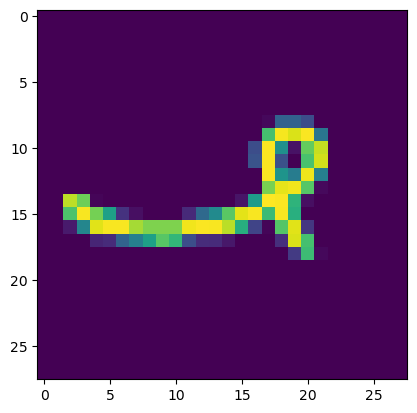

PyObject <matplotlib.image.AxesImage object at 0x7f2e8f23df60>

In [88]:
x1 = reshape(x[:,1]/maximum(x[:,1]), (28,28))
PyPlot.imshow(x1, vmin=0.0, vmax=1.0)

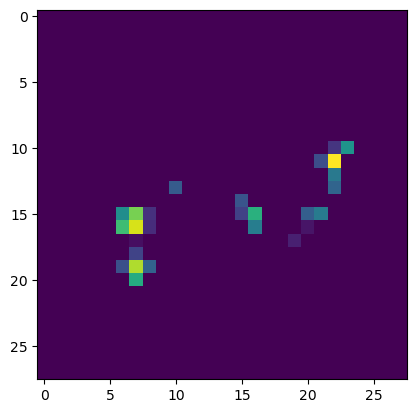

PyObject <matplotlib.image.AxesImage object at 0x7f2e8f1a51d0>

In [89]:
z1 = reshape(z[:,1]/maximum(z[:,1]), (28,28))
PyPlot.imshow(z1, vmin=0.0, vmax=1.0)